In [3]:
import os

import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
# String de conexão ao banco de dados PostgreSQL
DB_URL = os.environ.get("DATABASE_URL")


def carregar_dados_produtos():
    """Carrega dados de produtos e preços do banco de dados."""
    query = """
    WITH RECURSIVE dates AS (
        SELECT MIN(data_inicio::date) as date
        FROM historico_precos
        UNION ALL
        SELECT (date + INTERVAL '1 day')::date
        FROM dates
        WHERE date < (SELECT MAX(COALESCE(data_fim, CURRENT_DATE))::date FROM historico_precos)
    ),
    precos_diarios AS (
        SELECT
            p.id,
            p.categoria as categoria_completa,
            d.date AS data,
            hp.preco AS preco
        FROM PRODUTOS p
        JOIN HISTORICO_PRECOS hp ON p.id = hp.produto_id
        CROSS JOIN dates d
        WHERE p.categoria IS NOT NULL
            AND d.date >= hp.data_inicio::date
            AND (hp.data_fim IS NULL OR d.date <= hp.data_fim::date)
    )
    SELECT DISTINCT id, categoria_completa, data, preco
    FROM precos_diarios
    ORDER BY id, data;
    """
    df = pd.read_sql_query(query, DB_URL)
    df["data"] = pd.to_datetime(df["data"])
    return df


def extrair_nivel_categoria(df, nivel=1):
    """Extrai o nível especificado da hierarquia de categorias.

    Args:
        df: DataFrame com dados de produtos
        nivel: Nível da hierarquia (1=mais genérico)

    Returns:
        DataFrame filtrado com categorias do nível especificado

    """
    df_nivel = df.copy()
    df_nivel["categoria"] = df_nivel["categoria_completa"].str.split("/").str[nivel - 1]
    return df_nivel[df_nivel["categoria"].notna() & (df_nivel["categoria"] != "")]


def calcular_variacao_diaria(df_produtos):
    """Calcula variação percentual média diária por categoria.

    Considera apenas produtos disponíveis em dias consecutivos.
    """
    # Ordenar por produto e data
    df_ordenado = df_produtos.sort_values(["id", "data"])

    # Criar referências para dia e preço anteriores
    df_ordenado["data_anterior"] = df_ordenado.groupby("id")["data"].shift(1)
    df_ordenado["preco_anterior"] = df_ordenado.groupby("id")["preco"].shift(1)

    # Filtrar produtos com histórico de preços
    df_com_historico = df_ordenado.dropna(subset=["preco_anterior"]).copy()

    # Calcular diferença de dias entre registros consecutivos
    df_com_historico["dias_diff"] = (df_com_historico["data"] - df_com_historico["data_anterior"]).dt.days

    # Manter apenas registros de dias consecutivos
    df_dias_consecutivos = df_com_historico[df_com_historico["dias_diff"] == 1].copy()

    # Calcular variação percentual por produto
    df_dias_consecutivos.loc[:, "variacao_pct"] = (
        (df_dias_consecutivos["preco"] - df_dias_consecutivos["preco_anterior"])
        / df_dias_consecutivos["preco_anterior"]
        * 100
    )

    # Agregar por data e categoria
    df_variacao_diaria = (
        df_dias_consecutivos.groupby(["data", "categoria"])["variacao_pct"]
        .agg([("variacao_percentual_diaria", "mean"), ("contagem_produtos", "count")])
        .reset_index()
    )

    # Identificar primeira data de cada categoria
    df_primeiras_datas = df_produtos.groupby("categoria")["data"].min().reset_index()

    # Obter produtos das primeiras datas
    df_produtos_iniciais = df_primeiras_datas.merge(df_produtos[["data", "categoria", "id"]], on=["data", "categoria"])

    # Contar produtos por categoria na primeira data
    df_dados_iniciais = df_produtos_iniciais.groupby(["data", "categoria"]).size().reset_index(name="contagem_produtos")
    df_dados_iniciais["variacao_percentual_diaria"] = 0.0

    # Combinar dados iniciais com variações diárias
    return pd.concat([df_dados_iniciais, df_variacao_diaria], ignore_index=True)


def calcular_media_simples(df_variacao_diaria):
    """Calcula média simples das variações percentuais entre categorias."""
    media_simples = (
        df_variacao_diaria.groupby("data")
        .agg(
            variacao_percentual_diaria=("variacao_percentual_diaria", "mean"),
            contagem_produtos=("contagem_produtos", "sum"),
        )
        .reset_index()
    )
    media_simples["categoria"] = "Media Simples"
    return media_simples


def calcular_media_ponderada(df_variacao_diaria):
    """Calcula média ponderada das variações percentuais por quantidade de produtos."""
    media_ponderada = (
        df_variacao_diaria.groupby("data")
        .apply(
            lambda x: pd.Series(
                {
                    "variacao_percentual_diaria": np.average(
                        x["variacao_percentual_diaria"], weights=x["contagem_produtos"],
                    ),
                    "contagem_produtos": x["contagem_produtos"].sum(),
                },
            ),
            include_groups=False,
        )
        .reset_index()
    )
    media_ponderada["categoria"] = "Media Ponderada"
    return media_ponderada


def calcular_variacao_acumulada(df_variacao_diaria):
    """Calcula variação percentual acumulada para cada categoria."""
    df = df_variacao_diaria.copy().sort_values(["categoria", "data"])

    # Converter variações para fatores multiplicativos
    df["fator"] = 1 + (df["variacao_percentual_diaria"] / 100)

    # Calcular produto cumulativo por categoria
    df["fator_cumulativo"] = df.groupby("categoria")["fator"].cumprod()

    # Converter para percentual acumulado
    df["variacao_percentual_acumulada"] = df["fator_cumulativo"] * 100 - 100

    return df.drop(columns=["fator", "fator_cumulativo"]).sort_values(["categoria", "data"])


def analisar_variacao_precos(nivel_categoria=1, categoria_filtro=None):
    """Analisa variação de preços por categoria.

    Args:
        nivel_categoria: Nível hierárquico (1=genérico, 3=específico)
        categoria_filtro: Lista de categorias para filtrar ou None

    Returns:
        DataFrame com variações percentuais diárias e acumuladas

    """
    # Carregar dados
    df_original = carregar_dados_produtos()

    # Extrair categorias do nível desejado
    df_nivel = extrair_nivel_categoria(df_original, nivel_categoria)

    # Aplicar filtro de categorias
    if categoria_filtro:
        if isinstance(categoria_filtro, str):
            categoria_filtro = [categoria_filtro]
        df_nivel = df_nivel[df_nivel["categoria"].isin(categoria_filtro)]

    # Calcular variações e médias
    df_variacao_diaria = calcular_variacao_diaria(df_nivel)
    media_simples = calcular_media_simples(df_variacao_diaria)
    media_ponderada = calcular_media_ponderada(df_variacao_diaria)

    # Combinar resultados
    df_completo = pd.concat([df_variacao_diaria, media_simples, media_ponderada], ignore_index=True)

    return calcular_variacao_acumulada(df_completo)


# Executar análise com categorias de nível 1
df_variacao = analisar_variacao_precos(nivel_categoria=1)
df_variacao


,data,categoria,contagem_produtos,variacao_percentual_diaria,variacao_percentual_acumulada
925,2025-04-19,Media Ponderada,23.0,0.000000,0.000000
926,2025-04-20,Media Ponderada,23.0,0.000000,0.000000
927,2025-04-21,Media Ponderada,24.0,0.000000,0.000000
928,2025-04-22,Media Ponderada,24.0,0.000000,0.000000
929,2025-04-23,Media Ponderada,24.0,0.000000,0.000000
...,...,...,...,...,...
801,2025-06-15,utilidades-e-casa,3641.0,0.000000,-3.026981
818,2025-06-16,utilidades-e-casa,3645.0,-0.057257,-3.082505
835,2025-06-17,utilidades-e-casa,3636.0,-0.229138,-3.304580
852,2025-06-18,utilidades-e-casa,3654.0,-0.283558,-3.578767


In [14]:
import os

import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
# String de conexão ao banco de dados PostgreSQL
DB_URL = os.environ.get("DATABASE_URL")


def carregar_dados_produtos():
    """Carrega dados de produtos e preços do banco de dados."""
    query = """
    WITH RECURSIVE dates AS (
        SELECT MIN(data_inicio::date) as date
        FROM historico_precos
        UNION ALL
        SELECT (date + INTERVAL '1 day')::date
        FROM dates
        WHERE date < (SELECT MAX(COALESCE(data_fim, CURRENT_DATE))::date FROM historico_precos)
    ),
    precos_diarios AS (
        SELECT
            p.id as id_produto,
            p.categoria as categoria_completa,
            d.date AS data,
            hp.preco AS preco
        FROM PRODUTOS p
        JOIN HISTORICO_PRECOS hp ON p.id = hp.produto_id
        CROSS JOIN dates d
        WHERE p.categoria IS NOT NULL
            AND d.date >= hp.data_inicio::date
            AND (hp.data_fim IS NULL OR d.date <= hp.data_fim::date)
    )
    SELECT DISTINCT id_produto, categoria_completa, data, preco
    FROM precos_diarios
    ORDER BY id_produto, data;
    """
    df = pd.read_sql_query(query, DB_URL)
    df["data"] = pd.to_datetime(df["data"])
    return df


#dados = carregar_dados_produtos()
query = "SELECT * FROM historico_precos WHERE data_inicio = '2025-06-19';"
df = pd.read_sql_query(query, DB_URL)


In [15]:
df


,id,produto_id,cidade_id,preco,data_inicio,data_fim


In [11]:
df_variacao[:60]


,data,categoria,contagem_produtos,variacao_percentual_diaria,variacao_percentual_acumulada
925,2025-04-19,Media Ponderada,23.0,0.000000,0.000000
926,2025-04-20,Media Ponderada,23.0,0.000000,0.000000
927,2025-04-21,Media Ponderada,24.0,0.000000,0.000000
928,2025-04-22,Media Ponderada,24.0,0.000000,0.000000
929,2025-04-23,Media Ponderada,24.0,0.000000,0.000000
930,2025-04-24,Media Ponderada,24.0,0.000000,0.000000
931,2025-04-25,Media Ponderada,24.0,0.000000,0.000000
932,2025-04-26,Media Ponderada,3618.0,0.000000,0.000000
933,2025-04-27,Media Ponderada,22786.0,-0.205673,-0.205673
934,2025-04-28,Media Ponderada,22758.0,-3.053070,-3.252464


In [5]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


def grafico_categorias(df, categorias=None, figsize=(15, 10)):
    """Gera gráficos de variação percentual para categorias específicas.

    Parâmetros:
    df (DataFrame): DataFrame com colunas 'data', 'categoria' e 'soma'
    categorias (list): Lista de categorias para gerar gráficos. Se None, usa todas.
    figsize (tuple): Tamanho da figura
    """
    # Se categorias não for especificado, usar todas disponíveis
    if categorias is None:
        categorias = df["categoria"].unique().tolist()

    # Filtrar apenas as categorias solicitadas
    df_filtrado = df[df["categoria"].isin(categorias)]

    # Definir paleta de cores
    cores = plt.cm.tab20(np.linspace(0, 1, len(categorias)))

    plt.figure(figsize=figsize)
    plt.title("Variação Percentual Acumulada dos preços em Relação ao Primeiro Dia", fontsize=16)
    plt.xlabel("Data", fontsize=12)
    plt.ylabel("Variação Percentual Acumulada (%)", fontsize=12)
    plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Para armazenar as linhas para a legenda
    lines = []
    labels = []

    # Plotar cada categoria
    for i, categoria in enumerate(categorias):
        dados_cat = df_filtrado[df_filtrado["categoria"] == categoria]
        dados_cat = dados_cat.sort_values("data")

        cor = cores[i]
        (linha,) = plt.plot(
            dados_cat["data"],
            dados_cat["variacao_percentual_acumulada"],
            marker="o",
            linestyle="-",
            color=cor,
            label=categoria,
        )

        lines.append(linha)
        labels.append(categoria)

        if len(categorias) <= 3:  # Só adiciona anotações se houver menos que 3
            for _, row in dados_cat.iterrows():
                plt.annotate(
                    f"{row['variacao_percentual_acumulada']:.1f}%",
                    (row["data"], row["variacao_percentual_acumulada"]),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha="center",
                    color=cor,
                )

    # Adicionar legendas
    plt.legend(handles=lines, loc="best")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    plt.show()



### Todas as categorias disponives no nível 1

"açougue",
"bebê-e-infantil",
"bebidas",
"bebidas-alcoólicas",
"calçados",
"congelados--resfriados-e-sobremesas",
"frios-e-laticínios",
"higiene-e-perfumaria",
"hortifruti",
"limpeza",
"magazine",
"mercearia",
"padaria",
"papelaria",
"peixes",
"pet",
"utilidades-e-casa",
"Media Ponderada",
"Media Simples",


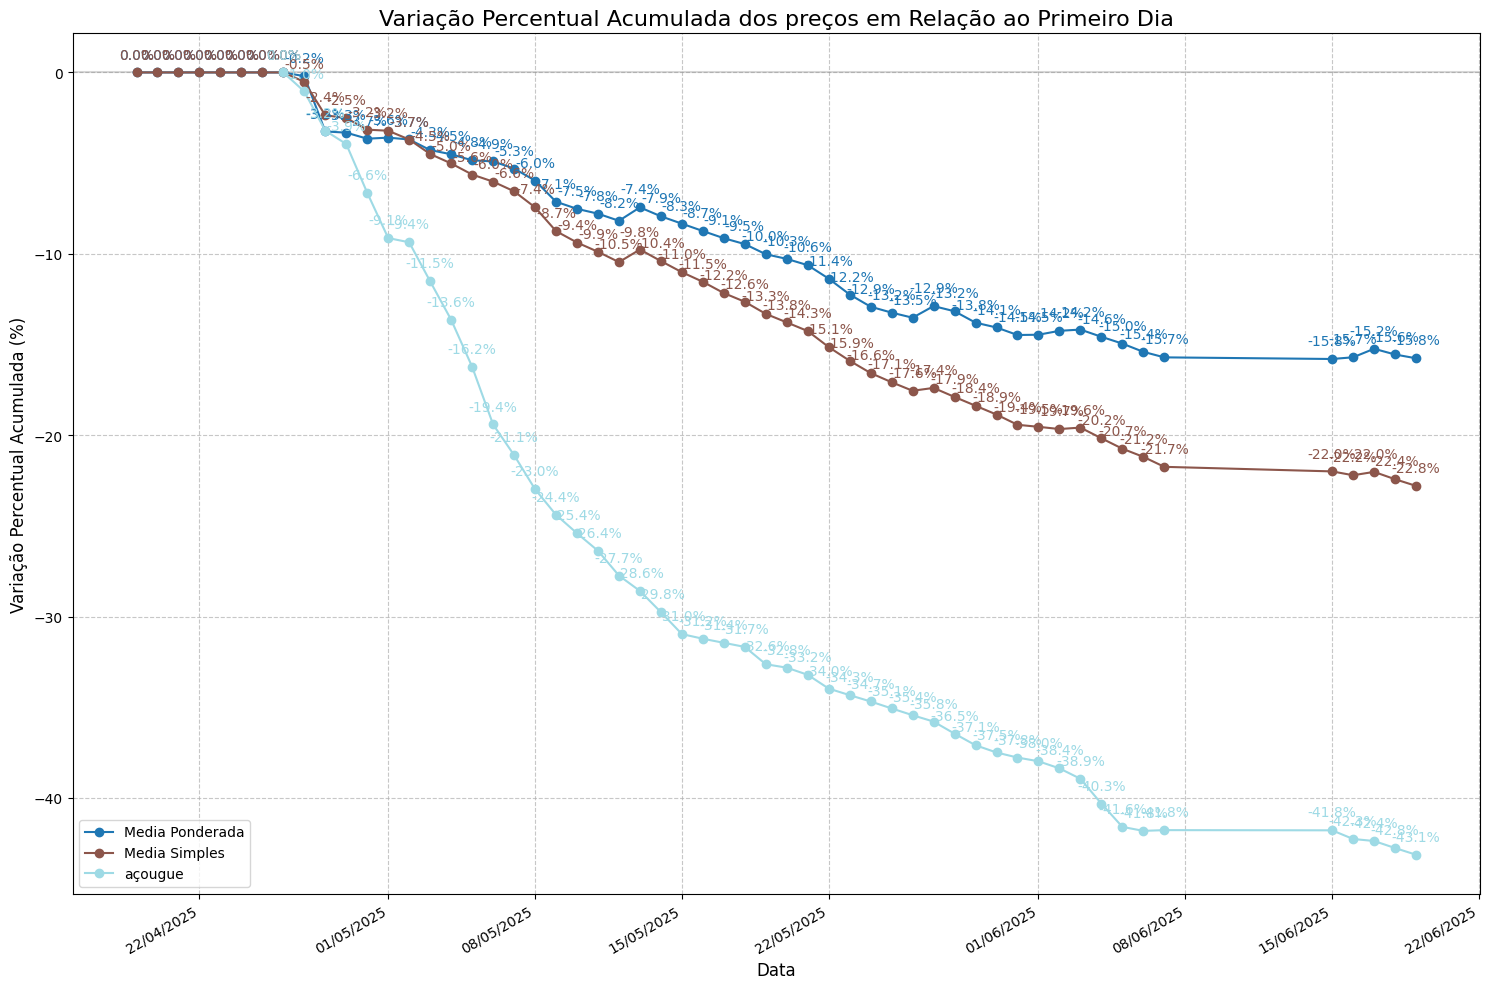

In [6]:

categorias = [
              "Media Ponderada",
              "Media Simples",
              "açougue",
              ]


grafico_categorias(df_variacao, categorias)
